### Setup
set working directory as the project directory

In [2]:
import os

if os.getcwd().endswith("notebooks"):
    os.chdir("..")
print(os.getcwd())

c:\Users\JAM5BG\OneDrive - Bosch Group\PersonalDrive\YT-tutorials\PyTorch Workflow Mastery - Cainã Max Couto da Silva


### Libraries

In [3]:
import torch
from torch import nn
from torch.optim import Adam, SGD
import torchmetrics
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.models import ResNet18_Weights, resnet18

from tqdm import tqdm
from loguru import logger

import numpy as np
import matplotlib.pyplot as plt

import wandb
from dotenv import load_dotenv

### Device (GPU or CPU)

In [4]:
# [Optional] Enable TF32 for better performance on modern NVIDIA GPUs
torch.set_float32_matmul_precision('high')

In [5]:
# Set available device (CPU or GPU - cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


### Config Params 

In [6]:
# Random seed
seed = 42

# Training parameters
num_epoch = 3
batch_size = 128 # Larger batches for faster training
learning_rate = 0.001

# Model parameters
num_classes = 10 # CIFAR10 has 10 classes
model_path = "weights/cifar10_model.pt" # Path to load model weights

# DataLoader settings
train_num_workers = 4 # Number of parallel processes for data loading
test_num_workers = 4  # Increase these if you have more CPU cores

In [7]:
## -- Set seeds -- ##

# CPU seed
torch.manual_seed(seed)  # Controls random number generation for PyTorch CPU operations

# NumPy seed (for data loading/processing)
np.random.seed(seed)     # Controls random number generation for NumPy operations

# If GPU is available
if torch.cuda.is_available():
    # GPU seed
    torch.cuda.manual_seed(seed)  # Controls random number generation for PyTorch GPU operations
    # Force CUDA to use deterministic algorithms
    torch.backends.cudnn.deterministic = False  # Makes GPU operations deterministic (might be slower)
    
# Set `deterministic = False` because we'll prioritize performance over reproducibility =S

### Weight & Biases Integration

In [19]:
# Load environment variables
load_dotenv()

# Verify API key is loaded (don't print in production)
assert os.getenv("WANDB_API_KEY") is not None, "WANDB_API_KEY is not found in environment variables"
print(os.getenv("WANDB_API_KEY"))

In [ ]:
# Rest of your wandb setup remains the same
wandb.init(
    project="pytorch-cifar10",
    config={
        "learning_rate": learning_rate,
        "epochs": num_epoch,
        "batch_size": batch_size,
        "model": "ResNet18",
        "optimizer": "Adam",
        "architecture": "Modified for CIFAR10"
    }
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

### Dataset

In [16]:
# Data Transformers

# Transformations like resizing and normalizaing alongside data augmentation
train_transformer = transforms.Compose([   
    transforms.ToTensor(),
    # Data Augmentation,
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Usually Resizing and normalizaton without data augmentation
val_transformer = transforms.Compose([     
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Usually same as validation transformation
test_transformer = transforms.Compose([     
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [17]:
## -- Download & load data -- ##

# Dataset
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transformer)
val_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transformer)

# DataLoaders
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=train_num_workers,
    pin_memory=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=train_num_workers,
    pin_memory=True
)

# Test dataset -> not available in this example,
# but real-life applications require test data - mainly when tuning hyperparameters!!

100%|██████████| 170M/170M [04:41<00:00, 606kB/s] 


In [18]:
train_dataset[0]

(tensor([[[-1.1075, -1.3815, -1.2617,  ...,  0.5878,  0.4851,  0.4166],
          [-1.8439, -2.1179, -1.8097,  ..., -0.0116, -0.0801, -0.0287],
          [-1.6898, -1.8439, -1.2788,  ..., -0.0972, -0.0629, -0.2513],
          ...,
          [ 1.4440,  1.3242,  1.2728,  ...,  0.6221, -1.1589, -1.2103],
          [ 0.9646,  0.8447,  1.0673,  ...,  1.0331, -0.4568, -0.6965],
          [ 0.9132,  0.7591,  0.9474,  ...,  1.5810,  0.4679, -0.0116]],
 
         [[-0.9503, -1.2304, -1.1954,  ...,  0.2752,  0.1527,  0.1352],
          [-1.6856, -2.0357, -1.8957,  ..., -0.4951, -0.5826, -0.5126],
          [-1.6155, -1.9132, -1.5630,  ..., -0.5651, -0.5651, -0.7577],
          ...,
          [ 0.9405,  0.6429,  0.7829,  ...,  0.2927, -1.4930, -1.4405],
          [ 0.3978,  0.1176,  0.4853,  ...,  0.5553, -0.9503, -1.1078],
          [ 0.4853,  0.2227,  0.4503,  ...,  1.1856,  0.0301, -0.4251]],
 
         [[-0.7064, -1.0201, -1.0550,  ...,  0.0779, -0.0267, -0.0092],
          [-1.4559, -1.8044,

In [19]:
train_dataset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

### Model

In [20]:
device

device(type='cpu')

In [21]:
ResNet18_Weights.IMAGENET1K_V1.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [22]:
# Load the model
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Modify the final layer for CIFAR-10 (10 classes)
model.fc = nn.Linear(model.fc.in_features, 10)

# Set it to target device
model = model.to(device)

# Optional step, compile model to make it faster (torch >= 2.0). With it code breaks !!!
# model = torch.compile(model)

# Set up loss function
criterion = nn.CrossEntropyLoss()

# Set up optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)

# Schedule for learning rate
# search torch scheduler

In [23]:
# Metrics
train_loss = torchmetrics.MeanMetric().to(device)
val_loss = torchmetrics.MeanMetric().to(device)
train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)
val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)

### Train

In [24]:
logger.info("Starting training...")

for epoch in range(num_epochs):

    ## -- Train step -- ##
    
    model.train()
    train_loss.reset()
    train_accuracy.reset()

    train_progress = tqdm(train_loader, desc=f'• Epoch {epoch + 1}/{num_epochs} [Train]', leave=False)

    for images, labels in train_progress:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        # Update metrics
        train_loss.update(loss)
        train_accuracy.update(outputs, labels)

        train_progress.set_postfix({
            'loss': f'{train_loss.compute():.3f}',
            'acc': f'{train_accuracy.compute():.1%}'
        })

    ## -- Validation step -- ##

    model.eval()
    val_loss.reset()
    val_accuracy.reset()

    with torch.inference_mode():
        val_progress = tqdm(
            val_loader, desc=f'• Epoch {epoch + 1}/{num_epochs} [Valid]', leave=False
        )

        for images, labels in val_progress:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Update metrics
            val_loss.update(loss)
            val_accuracy.update(outputs, labels)
            
            val_progress.set_postfix({
                'loss': f'{val_loss.compute():.3f}',
                'acc': f'{val_accuracy.compute():.1%}'
            })

    # Print epoch summary
    logger.debug(
        f"Epoch {epoch+1}/{num_epochs}: "
        f"Train Loss: {train_loss.compute():.3f} | "
        f"Train Acc: {train_accuracy.compute():.1%} | "
        f"Val Loss: {val_loss.compute():.3f} | "
        f"Val Acc: {val_accuracy.compute():.1%}"
    )

    # Log to wandb
    wandb.log({
        'epoch': epoch,
        'train_loss': train_loss.compute(),
        'train_accuracy': train_accuracy.compute(),
        'val_loss': val_loss.compute(),
        'val_accuracy': val_accuracy.compute()
    })

logger.success('Model trained!')

2025-04-24 11:35:53.423 | INFO     | __main__:<module>:1 - starting training...
2025-04-24 12:05:28.877 | DEBUG    | __main__:<module>:61 - Epoch 1/3: Train Loss: 0.888 | Train Acc: 69.9% | Val Loss: 0.685 | Val Acc: 76.7%
2025-04-24 12:16:19.874 | DEBUG    | __main__:<module>:61 - Epoch 2/3: Train Loss: 0.570 | Train Acc: 80.8% | Val Loss: 0.647 | Val Acc: 78.1%
2025-04-24 12:27:20.496 | DEBUG    | __main__:<module>:61 - Epoch 3/3: Train Loss: 0.438 | Train Acc: 85.2% | Val Loss: 0.624 | Val Acc: 79.4%
2025-04-24 12:27:20.499 | SUCCESS  | __main__:<module>:69 - Model trained!


In [25]:
import os

os.makedirs(os.path.dirname(model_path), exist_ok=True)

# Save fine-tuned model and training state
torch.save({
   'model_state_dict': model.state_dict(),          # Model weights
   'optimizer_state_dict': optimizer.state_dict(),  # Optimizer state
   'epoch': num_epoch,                              # Number of trained epochs
}, model_path)

logger.info(f"Model saved to {model_path}")

2025-04-24 12:27:20.849 | INFO     | __main__:<module>:12 - Model saved to weights/cifar10_model.pt


### Inference

In [26]:
# Load checkpoint
checkpoint = torch.load(model_path, weights_only=True)

# Initialize model architecture
model = resnet18()
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Compile model as training
model = model.to(device) 
# model = torch.compile(model)

# Load model weights
model.load_state_dict(checkpoint['model_state_dict']);

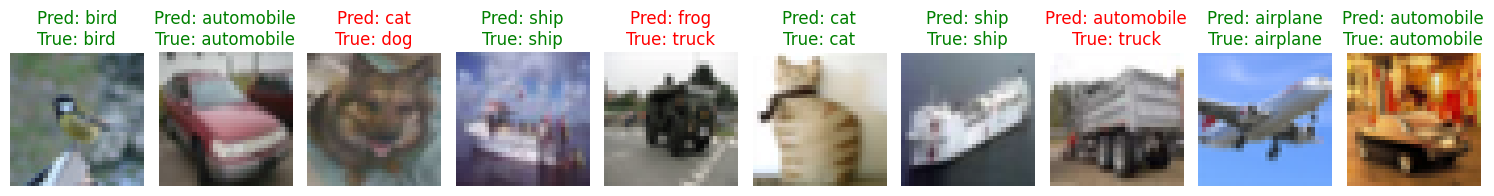

In [27]:

# Set random seed for reproducibility
np.random.seed(42)

# Number of samples to visualize
n_samples = 10

# Get random indices
val_indices = np.random.choice(len(val_dataset), size=n_samples, replace=False)

# Set up the plot
plt.figure(figsize=(15, 3))

# Get class names from CIFAR10
classes = val_dataset.classes

model.eval()
with torch.inference_mode():
    for idx, sample_idx in enumerate(val_indices):

        # Get the image and label
        image, true_label = val_dataset[sample_idx]
        
        # Add batch dimension and move to device
        image = image.unsqueeze(0).to(device)
        
        # Get prediction
        output = model(image)
        predicted_label = output.argmax(1).item()
        
        # Convert image for display
        img = image.cpu().squeeze()
        img = img.permute(1, 2, 0)  # Change from CxHxW to HxWxC
        
        # Denormalize the image
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        img = img * std + mean
        
        # Plot
        plt.subplot(1, n_samples, idx + 1)
        plt.imshow(img)
        plt.axis('off')
        color = 'green' if predicted_label == true_label else 'red'
        plt.title(
            f'Pred: {classes[predicted_label]}\n'
            f'True: {classes[true_label]}',
            color=color
        )

plt.tight_layout()
plt.show()